In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
from rubin_scheduler.data import get_baseline

from rubin_scheduler.utils import int_binned_stat


In [2]:
baseline_file = get_baseline() #'/Users/yoachim/runs34/long_gaps/all_long_v3.4_10yrs.db' # get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

In [ ]:
# should add a little summary metric that is mean per sq degree

In [3]:
class CheckColorSlope(object):
    """Check if the data has a color and a slope
    """

    def __init__(self, color_length=1., slope_length=3.,
                 filter_col="filter", mjd_col="observationStartMJD"):
        self.color_length = color_length/24.
        self.slope_length = slope_length/24.

        self.filter_col = filter_col
        self.mjd_col=mjd_col

    def __call__(self, data_slice):
        has_color = False
        has_slope = False

        if np.size(data_slice) < 3:
            return 0
        try:
            filters = data_slice[self.filter_col] #.astype(str)
        except:
            import pdb ; pdb.set_trace()

        u_filters = np.unique(filters)

        for filtername in u_filters:
            in_filt = np.where(data_slice[self.filter_col] == filtername)[0]
            time_gaps = data_slice[self.mjd_col][in_filt] - data_slice[self.mjd_col][in_filt][np.newaxis].T
            if np.max(time_gaps) >- self.slope_length:
                has_slope = True
                break
        for filtername1 in u_filters:
            for filtername2 in u_filters:
                if filtername1 != filtername2:
                    in_filt1 = np.where(filters == filtername1)[0]
                    in_filt2 = np.where(filters == filtername1)[0]
                    time_gaps = data_slice[self.mjd_col][in_filt1] - data_slice[self.mjd_col][in_filt2][np.newaxis].T
                    if np.min(time_gaps) <= self.color_length:
                        has_color = True
                        break
        if has_color & has_slope:
            return 1
        else:
            return 0


class ColorSlopeMetric(maf.BaseMetric):
    """How many times do we get a color and slope in a night
    """
    def __init__(self, mag=20, night_col="night", filter_col="filter", 
                 m5_col="fiveSigmaDepth", binsize=1,
                 color_length=1., slope_length=3.,
                 time_col="observationStartMJD", units='#',
                 metric_name="ColorSlope", **kwargs):
        cols = [filter_col, night_col, m5_col, time_col]

        self.night_col = night_col
        self.filter_col = filter_col
        self.m5_col = m5_col
        self.mag = mag
        self.time_col = time_col
        
        super().__init__(col=cols, units=units, metric_name=metric_name, **kwargs)

        self.sequence_checker = CheckColorSlope(color_length=color_length,
                                                slope_length=slope_length)

    def run(self, data_slice, slice_point=None):

        result = 0
        deep_enough = np.where(data_slice[self.m5_col] > self.mag)[0]
        data = data_slice[deep_enough]
        if data.size > 0:
            _night, result = int_binned_stat(data[self.night_col], data, statistic=self.sequence_checker)

        return np.sum(result)


class ColorSlope2NightMetric(ColorSlopeMetric):
    """Like ColorSlopeMetric, but span over 2 nights
    """
    def __init__(self, mag=18, night_col="night", filter_col="filter", 
                 m5_col="fiveSigmaDepth",
                 color_length=1., slope_length=15.,
                 time_col="observationStartMJD", units='#',
                 metric_name="ColorSlope2Night", **kwargs):

        super().__init__(night_col=night_col, filter_col=filter_col,
                        m5_col=m5_col, color_length=color_length, slope_length=slope_length,
                        time_col=time_col, units=units, metric_name=metric_name, **kwargs)
    
    def run(self, data_slice, slice_point=None):

        result = 0
        deep_enough = np.where(data_slice[self.m5_col] > self.mag)[0]
        data = data_slice[deep_enough]
        if data.size > 0:
            
            # Send in nights as pairs, (0,1) (2,3), (4,5), etc
            night_id = np.floor(data[self.night_col]/2).astype(int)
            _night, result1 = int_binned_stat(night_id, data, statistic=self.sequence_checker)

            # Now to do pairs (1,2), (3,4)
            night_id = np.ceil(data[self.night_col]/2).astype(int)
            _night, result2 = int_binned_stat(night_id, data, statistic=self.sequence_checker)

            result = np.sum(result1) + np.sum(result2)
        
        return result


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


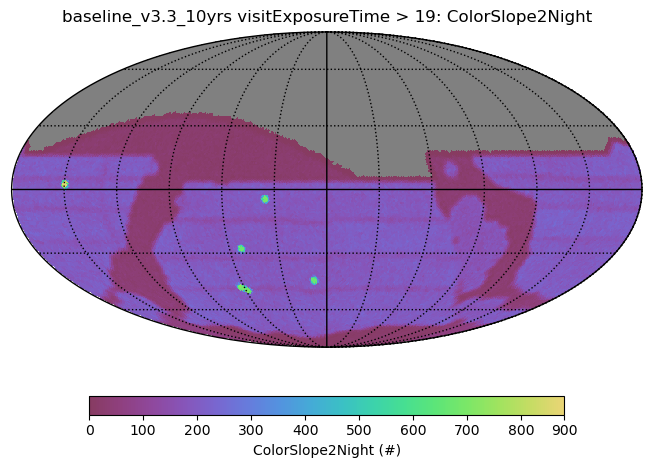

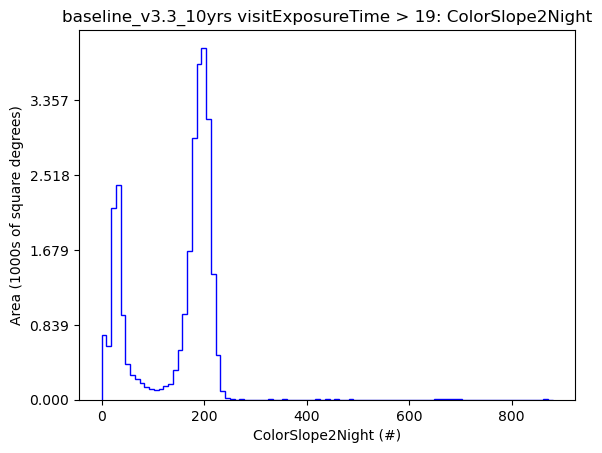

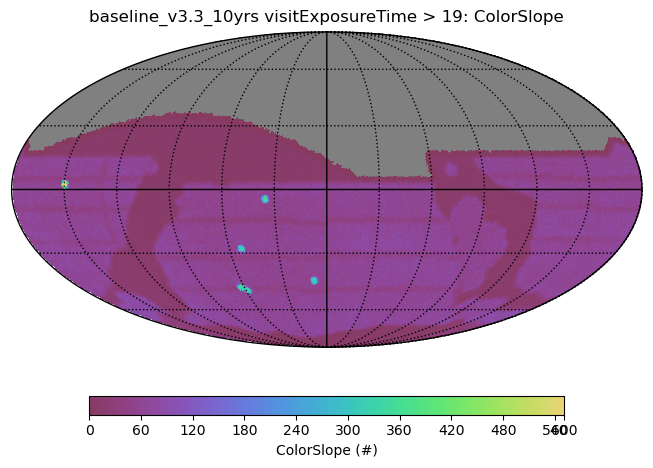

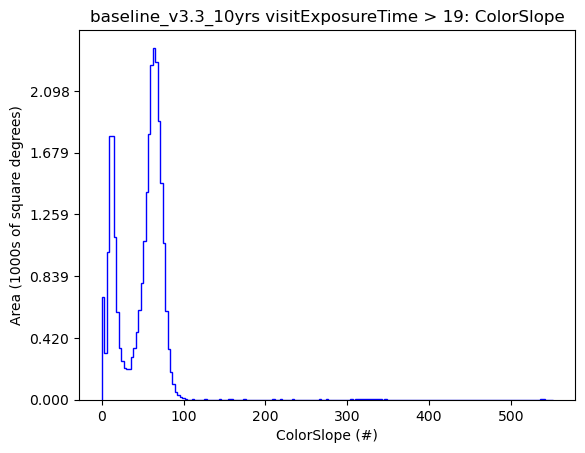

In [4]:
bundle_list = []

metric = ColorSlope2NightMetric()
# Select all the visits. Could do something like 'filter="r"' 
sql = 'visitExposureTime > 19'
slicer = maf.slicers.HealpixSlicer(nside=64)
plot_dict = {}
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, plot_dict=plot_dict))

metric = ColorSlopeMetric()
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name, plot_dict=plot_dict))


bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()
bg.plot_all(closefigs=False)

In [5]:
bundle_list[0].metric_values.mean()

145.43448871419213

In [6]:
nights = np.arange(10)

In [7]:
nights

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
np.ceil(nights/2)

array([0., 1., 1., 2., 2., 3., 3., 4., 4., 5.])

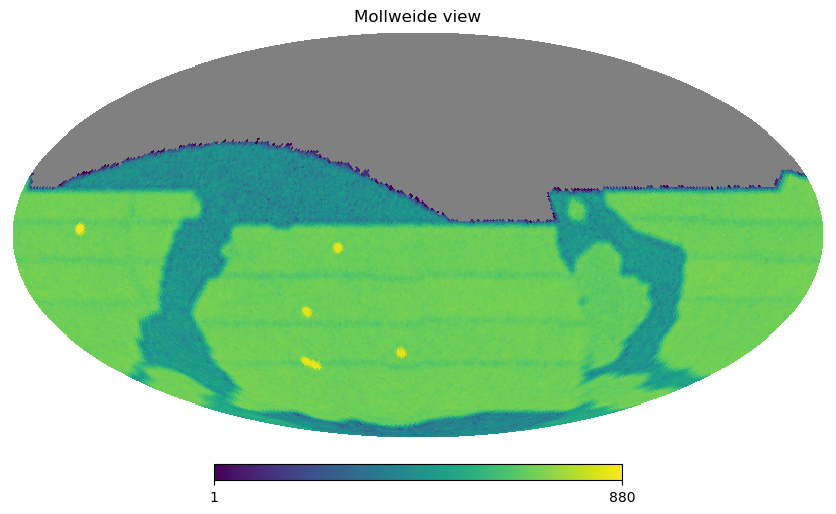

In [9]:
hp.mollview(bundle_list[0].metric_values, min=1, norm='log')

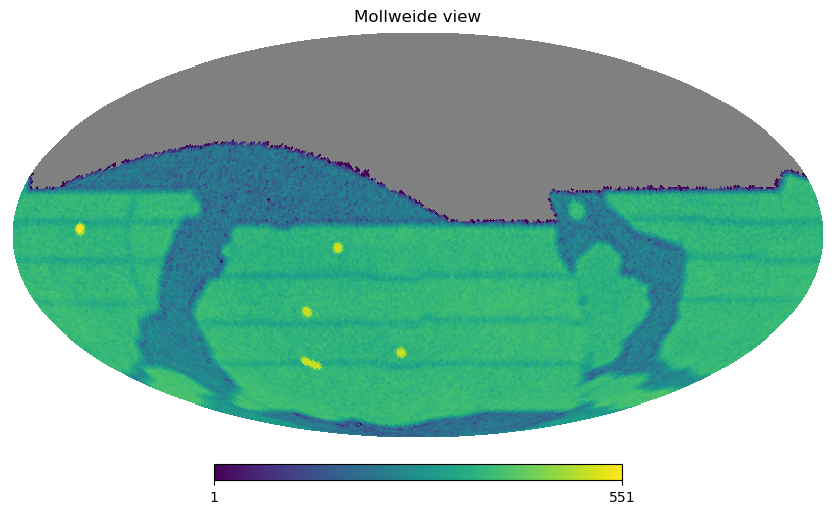

In [10]:
hp.mollview(bundle_list[1].metric_values, min=1, norm='log')